In [1]:
#!pip install qulacs
#!pip install matplotlib
#!pip install numpy
#!pip install scipy

In [2]:
from qulacs import Observable, QuantumState, QuantumCircuit, ParametricQuantumCircuit
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# エラー補償手法について学ぶ

## 量子状態に対するエラー
まずは量子状態に対するエラーの理解を確認します。簡単な例として、$R_x(\theta)$ の回転ゲートを作用させたあと、確率 $p$ で $X$ ゲートがかかってしまうというモデル (ビット反転ノイズ) を考えます。以下は $\theta = [0,2\pi]$, $p=0.1, 0.2, 0.4$ について 1 が出る確率を計算して、結果をプロットするコードです。
([ラムゼー干渉](02_Ramsay.ipynb) のノイズありバージョンも参考。)

まずは $\theta, p$ を受けとって、そのときの 1 が出る確率を出力する関数を用意します。

In [10]:
from qulacs.gate import RX, X
def get_one_prob(theta, p_noise, n_shots):
    one_prob = 0
    for _ in range(n_shots):
        state = QuantumState(1)
        RX(0, theta).update_quantum_state(state)
        if np.random.random() < p_noise:
            X(0).update_quantum_state(state)
        one_prob += state.sampling(1)[0]
    return one_prob/n_shots

上記関数を使って、結果をプロットします。

In [5]:
theta_list = np.linspace(0, 2*np.pi, 100)
n_shots = 1000
p_noise_list = [0.1, 0.2, 0.4]
result_list = []
for p_noise in p_noise_list:
    res = np.array([get_one_prob(theta, p_noise, n_shots) for theta in theta_list])
    result_list.append(res)

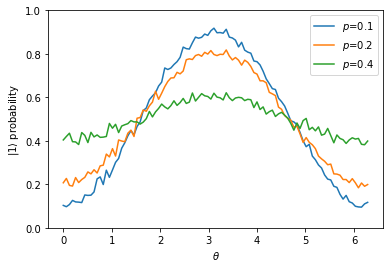

In [9]:
for p_noise, res in zip(p_noise_list, result_list):
    plt.plot(theta_list, res, label=f"$p$={p_noise}")
plt.ylim(0,1)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$|1\rangle$ probability")
plt.legend()

ノイズ強度が強くなるほどに、振幅が小さくなっていくことが確認できます。

## 外挿によるエラー補償